In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, kstest, kurtosis, skew
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

This notebook takes the individual datasets processed at their processed stage and converts them into a concise dataset. This dataset is further summarized and pre-processed through stationarity testing and standardization exercise. It also created visualizations and produce tables.

Important note: Variables NegGenAIECBCovid and FEDSpeechCovid have been feature engineered during the modelling exercise. Thus, those are created using standardized variables, and are not present in the initial two datasets. It has been manually imputed into the thesis to ensure consistency.

Inputs:
- all datasets highilighted in the Data Lineage in chapter three

Output:
- __"finaldataset_preproc.csv"__ = Full concatenated dataset before preprocessing.
- __"finaldataset_non.csv"__ = Fully processed and differenced dataset before standardization.
- __"finaldataset.csv"__ = Final standardized modelling dataset that will be used for modelling exercise.

In [5]:
GoogleBitcoin = pd.read_csv("GoogleBitcoin.csv")
GoogleCrypto = pd.read_csv("GoogleCrypto.csv")
WikiBitcoin = pd.read_csv("WikiBitcoin.csv")
yfdata = pd.read_csv("yfdata.csv")

CryptoVars = pd.read_csv("CryptoInfo.csv", sep =";")
CryptoVars = CryptoVars[CryptoVars.index >= 96]
CryptoVars = CryptoVars[(CryptoVars.index <= 1455)].reset_index(drop=True)
CryptoVars.columns = ["Time", "BTCUSD", "ActAdd", "Hashrate", "Fees", "Inflation", "Velocity"]

Volatilities = pd.read_csv("HighFrequency.csv").iloc[1:, :]
Volatilities.columns = ["Date", "RealizedVariance" , "RealizedVolatility", "DailyVolatility", "WeeklyVolatility", "MonthlyVolatility"]

Speeches = pd.read_csv("AllSpeachesSent.csv").iloc[:,1:]

In [6]:
def create_dummies_and_prepare_variables(df):
    # Variables used to generate more niche columns
    df["SentimentGenAIPositive"] = (df["SentimentGenAI"] > 0.10).apply(int)
    df["SentimentGenAINegative"] = (df["SentimentGenAI"] < -0.10).apply(int)
    df["SentimentFinBERTPositive"] = (df["SentimentFinBERT"] > 0.10).apply(int)
    df["SentimentFinBERTNegative"] = (df["SentimentFinBERT"] < -0.10).apply(int)
    
    # Further variables
    df['NegGenAICovidECB'] = df['SentimentGenAINegative'] * df['Covid'] * df['ECB']
    df['NegFinBERTCovidECB'] = df['SentimentFinBERTNegative'] * df['Covid'] * df['ECB']
    
    return df

In [7]:
for i in ["IsNegativeFinBERT", "IsNegativeGenAI", "ECB", "FED", "MonetaryDecision", "PressRelease", "Speech"]:
    Speeches[i] = Speeches[i].astype(int)
Speeches["Statement"] = 1
Speeches

,Date,SentimentFinBERT,IsNegativeFinBERT,IsPositiveFinBERT,SentimentGenAI,IsNegativeGenAI,IsPositiveGenAI,ECB,FED,MonetaryDecision,PressRelease,Speech,Statement
0,2018-01-03,0.02,1,1,0.05,0,1,0,1,0,1,0,1
1,2018-01-04,0.03,1,1,0.17,0,1,0,1,0,1,0,1
2,2018-01-09,0.14,0,1,0.10,0,1,0,1,0,1,0,1
3,2018-01-10,0.02,0,1,0.15,0,1,0,1,0,1,0,1
4,2018-01-11,0.02,1,1,0.25,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,2021-09-07,0.10,0,1,0.10,0,1,0,1,0,1,0,1
744,2021-09-09,0.21,1,1,0.20,1,1,1,1,1,1,1,1
745,2021-09-13,0.04,0,1,0.40,0,1,1,0,0,1,1,1
746,2021-09-15,0.08,0,1,0.10,0,1,1,0,0,0,1,1


In [9]:
# Concatenating dataset with same number of entries
cryptodataset = pd.concat([GoogleBitcoin, GoogleCrypto, WikiBitcoin, CryptoVars], axis=1)

# Merging yfdata due to missing weekend entries, substituing those with zero
cryptodataset = pd.merge(cryptodataset, yfdata, on='Date', how='left').fillna(0)
cryptodataset = pd.merge(cryptodataset, Volatilities, on='Date', how='left').fillna(0)

print(cryptodataset.head())
# Cleaning up the data and setting the column names
cryptodataset.columns = ["GoogleBitcoin", "GoogleCrypto", "Date", "WikiBitcoin", "ERASE", "BTCinUSD", "ActAddresses", "Hashrate", "BTCFees", "Inflation", "Velocity", "EURUSDLret", "SP500Lret", "VIX", "RealizedVariance", "RealizedVolatility", "DailyVolatility", "WeeklyVolatility", "MonthlyVolatility"] 
cryptodataset = cryptodataset[["Date", "BTCinUSD", "ActAddresses", "Hashrate", "BTCFees", "Inflation", "Velocity", "VIX", "SP500Lret", "EURUSDLret", "GoogleBitcoin", "GoogleCrypto", "WikiBitcoin", "RealizedVariance", "RealizedVolatility", "DailyVolatility", "WeeklyVolatility", "MonthlyVolatility"]]
cryptodataset["Date"] = pd.to_datetime(cryptodataset["Date"])
Speeches["Date"] = pd.to_datetime(Speeches["Date"])
cryptodataset = pd.merge(cryptodataset, Speeches, on='Date', how='left').fillna(0)

# Dummyfing sentiment variables to separate negative and positive shocks + adding Covid distinction
cryptodataset["Date"] = pd.to_datetime(cryptodataset["Date"])
#cryptodataset.set_index("Date", inplace=True, drop=True)

cryptodataset["Covid"] = ((cryptodataset["Date"]) >= pd.Timestamp('2020-03-11')).astype(int)

#cryptodataset.to_csv("finaldataset_preproc.csv")
cryptodataset

   Bitcoin  Cryptocurrency        Date  Bitcoin        Time       BTCUSD   
0    15.75           38.95  2018-01-01    65416  2018-01-01  13464,65361  \
1    20.70           50.35  2018-01-02    85549  2018-01-02   14754,3222   
2    20.70           71.25  2018-01-03    91452  2018-01-03  15010,28616   
3    17.55           86.45  2018-01-04    86342  2018-01-04   15070,3008   
4    20.25           77.90  2018-01-05    79232  2018-01-05  16997,22741   

    ActAdd     Hashrate         Fees    Inflation     Velocity  EURUSDLret   
0   972783  14923655,72  26,59357104  4,242579941  49,91509162    0.000000  \
1  1142721  16415540,67  27,90083173  4,649927866  41,63040382    0.000060   
2  1130917  15071578,27  28,36188043  4,268732724  44,70739876    0.000121   
3  1253986  16127548,73  27,56812754  4,567244338  34,29180194   -0.000072   
4  1069525  13727615,88  35,26792803  3,887180861  32,28714867    0.000217   

   SP500Lret   VIX  RealizedVariance  RealizedVolatility  DailyVolatility 

,Date,BTCinUSD,ActAddresses,Hashrate,BTCFees,Inflation,Velocity,VIX,SP500Lret,EURUSDLret,...,SentimentGenAI,IsNegativeGenAI,IsPositiveGenAI,ECB,FED,MonetaryDecision,PressRelease,Speech,Statement,Covid
0,2018-01-01,"13464,65361",972783,"14923655,72","26,59357104","4,242579941","49,91509162",0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2018-01-02,"14754,3222",1142721,"16415540,67","27,90083173","4,649927866","41,63040382",9.770000,0.004491,0.000060,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2018-01-03,"15010,28616",1130917,"15071578,27","28,36188043","4,268732724","44,70739876",9.150000,0.005622,0.000121,...,0.05,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
3,2018-01-04,"15070,3008",1253986,"16127548,73","27,56812754","4,567244338","34,29180194",9.220000,0.001720,-0.000072,...,0.17,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
4,2018-01-05,"16997,22741",1069525,"13727615,88","35,26792803","3,887180861","32,28714867",9.220000,0.004318,0.000217,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2021-09-17,"47213,79413",943981,134567094,"2,587788056","1,781975589","71,31903088",20.809999,-0.008256,0.000224,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1356,2021-09-18,"48204,01365",819880,"141890473,9","2,445871653","1,878857137","112,7841753",0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1357,2021-09-19,"47218,474",714326,"146467585,7","1,953428269","1,939362384","199,1412845",0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1358,2021-09-20,"42855,51034",1014971,"150129275,6","2,219486881","1,98773817","43,65403317",25.709999,-0.010324,0.000094,...,0.40,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1


Now that we have the dataset, let's perform check on the normality, stationarity and standardize it.

In [10]:
processed = pd.read_csv("finaldataset_preproc.csv").iloc[:,1:]

# Looking at different datatypes:
print("Distinct data types:")
print(processed.dtypes)

Distinct data types:
Date                   object
BTCinUSD               object
ActAddresses            int64
Hashrate               object
BTCFees                object
Inflation              object
Velocity               object
VIX                   float64
SP500Lret             float64
EURUSDLret            float64
GoogleBitcoin         float64
GoogleCrypto          float64
WikiBitcoin             int64
RealizedVariance      float64
RealizedVolatility    float64
DailyVolatility       float64
WeeklyVolatility      float64
MonthlyVolatility     float64
SentimentFinBERT      float64
IsNegativeFinBERT     float64
IsPositiveFinBERT     float64
SentimentGenAI        float64
IsNegativeGenAI       float64
IsPositiveGenAI       float64
ECB                   float64
FED                   float64
MonetaryDecision      float64
PressRelease          float64
Speech                float64
Statement             float64
Covid                   int64
dtype: object


In [11]:
#processed.index = pd.to_datetime(processed["Date"])
processed["BTCinUSD"] = processed['BTCinUSD'].str.replace(',', '.').astype('float64')
logrets = np.log(processed['BTCinUSD'] / processed['BTCinUSD'].shift(1))
processed["Hashrate"] = processed['Hashrate'].str.replace(',', '.').astype('float64')
processed["BTCFees"] = processed['BTCFees'].str.replace(',', '.').astype('float64')
processed["Inflation"] = processed['Inflation'].str.replace(',', '.').astype('float64')
processed["Velocity"] = processed['Velocity'].str.replace(',', '.').astype('float64')
for col in ["IsPositiveFinBERT", "IsNegativeFinBERT", "IsNegativeGenAI", "IsPositiveGenAI", "ECB", "FED", "MonetaryDecision", "PressRelease", "Speech", "Statement"]:
    processed[col] = processed[col].astype(int)

print("Distinct corrected dtypes:")
processed.dtypes

Distinct corrected dtypes:


Date                   object
BTCinUSD              float64
ActAddresses            int64
Hashrate              float64
BTCFees               float64
Inflation             float64
Velocity              float64
VIX                   float64
SP500Lret             float64
EURUSDLret            float64
GoogleBitcoin         float64
GoogleCrypto          float64
WikiBitcoin             int64
RealizedVariance      float64
RealizedVolatility    float64
DailyVolatility       float64
WeeklyVolatility      float64
MonthlyVolatility     float64
SentimentFinBERT      float64
IsNegativeFinBERT       int64
IsPositiveFinBERT       int64
SentimentGenAI        float64
IsNegativeGenAI         int64
IsPositiveGenAI         int64
ECB                     int64
FED                     int64
MonetaryDecision        int64
PressRelease            int64
Speech                  int64
Statement               int64
Covid                   int64
dtype: object

Good, let's check also the NAs:

In [12]:
processed.isna().sum()

Date                  0
BTCinUSD              0
ActAddresses          0
Hashrate              0
BTCFees               0
Inflation             0
Velocity              0
VIX                   0
SP500Lret             0
EURUSDLret            0
GoogleBitcoin         0
GoogleCrypto          0
WikiBitcoin           0
RealizedVariance      0
RealizedVolatility    0
DailyVolatility       0
WeeklyVolatility      0
MonthlyVolatility     0
SentimentFinBERT      0
IsNegativeFinBERT     0
IsPositiveFinBERT     0
SentimentGenAI        0
IsNegativeGenAI       0
IsPositiveGenAI       0
ECB                   0
FED                   0
MonetaryDecision      0
PressRelease          0
Speech                0
Statement             0
Covid                 0
dtype: int64

In [13]:
processed

,Date,BTCinUSD,ActAddresses,Hashrate,BTCFees,Inflation,Velocity,VIX,SP500Lret,EURUSDLret,...,SentimentGenAI,IsNegativeGenAI,IsPositiveGenAI,ECB,FED,MonetaryDecision,PressRelease,Speech,Statement,Covid
0,2018-01-01,13464.65361,972783,1.492366e+07,26.593571,4.242580,49.915092,0.000000,0.000000,0.000000,...,0.00,0,0,0,0,0,0,0,0,0
1,2018-01-02,14754.32220,1142721,1.641554e+07,27.900832,4.649928,41.630404,9.770000,0.004491,0.000060,...,0.00,0,0,0,0,0,0,0,0,0
2,2018-01-03,15010.28616,1130917,1.507158e+07,28.361880,4.268733,44.707399,9.150000,0.005622,0.000121,...,0.05,0,1,0,1,0,1,0,1,0
3,2018-01-04,15070.30080,1253986,1.612755e+07,27.568128,4.567244,34.291802,9.220000,0.001720,-0.000072,...,0.17,0,1,0,1,0,1,0,1,0
4,2018-01-05,16997.22741,1069525,1.372762e+07,35.267928,3.887181,32.287149,9.220000,0.004318,0.000217,...,0.00,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2021-09-17,47213.79413,943981,1.345671e+08,2.587788,1.781976,71.319031,20.809999,-0.008256,0.000224,...,0.00,0,0,0,0,0,0,0,0,1
1356,2021-09-18,48204.01365,819880,1.418905e+08,2.445872,1.878857,112.784175,0.000000,0.000000,0.000000,...,0.00,0,0,0,0,0,0,0,0,1
1357,2021-09-19,47218.47400,714326,1.464676e+08,1.953428,1.939362,199.141285,0.000000,0.000000,0.000000,...,0.00,0,0,0,0,0,0,0,0,1
1358,2021-09-20,42855.51034,1014971,1.501293e+08,2.219487,1.987738,43.654033,25.709999,-0.010324,0.000094,...,0.40,0,1,1,0,0,0,1,1,1


In [14]:
# Plain dataset
numerical = processed.select_dtypes(include=['float64', 'int64'])
# Initialize lists to store statistics
means, medians, stdevs, skews, kurtoses, p_stationarity, p_trendstat, p_normality = [], [], [], [], [], [], [], []

# Calculate statistics for each column
for col in numerical.columns:
    means.append(round(numerical[col].mean(), 3))
    medians.append(round(numerical[col].median(), 3))
    stdevs.append(round(numerical[col].std(), 3))
    skews.append(round(skew(numerical[col]), 3))
    kurtoses.append(round(kurtosis(numerical[col], fisher=True), 3))
    p_stationarity.append(adfuller(numerical[col])[1])  # p-value from Augmented Dickey-Fuller test
    p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
    p_normality.append(shapiro(numerical[col])[1])      # p-value from Shapiro-Wilk test

# Create a new df for the statistics
stats_df = pd.DataFrame({
    'Variable': numerical.columns,
    'Mean': means,
    'Median': medians,
    'SD': stdevs,
    'Skews': skews,
    'Kurt': kurtoses,
    'ADF': p_stationarity,
    'KPSS': p_trendstat,
    'Norm': p_normality
})

# Rounding to three decimal numbers
stats_df = stats_df.round(3)

# Export to LaTeX
latex_code = stats_df.style.to_latex()
print(latex_code)
stats_df

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/838695073.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/838695073.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/838695073.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
/var/folders/7s/

\begin{tabular}{llrrrrrrrr}
 & Variable & Mean & Median & SD & Skews & Kurt & ADF & KPSS & Norm \\
0 & BTCinUSD & 15651.062000 & 9230.114000 & 15160.231000 & 1.653000 & 1.360000 & 0.874000 & 0.010000 & 0.000000 \\
1 & ActAddresses & 806392.427000 & 775267.000000 & 191826.945000 & 0.445000 & -0.578000 & 0.342000 & 0.010000 & 0.000000 \\
2 & Hashrate & 86884951.356000 & 90878697.695000 & 44639298.448000 & 0.171000 & -1.194000 & 0.544000 & 0.010000 & 0.000000 \\
3 & BTCFees & 4.345000 & 1.448000 & 7.239000 & 3.316000 & 14.584000 & 0.021000 & 0.010000 & 0.000000 \\
4 & Inflation & 3.092000 & 3.534000 & 1.073000 & -0.317000 & -1.462000 & 0.279000 & 0.010000 & 0.000000 \\
5 & Velocity & 80.350000 & 73.278000 & 30.202000 & 1.312000 & 2.206000 & 0.001000 & 0.010000 & 0.000000 \\
6 & VIX & 13.993000 & 14.775000 & 12.096000 & 1.042000 & 3.050000 & 0.003000 & 0.010000 & 0.000000 \\
7 & SP500Lret & 0.000000 & 0.000000 & 0.008000 & -0.588000 & 11.476000 & 0.000000 & 0.100000 & 0.000000 \\
8 & EURUS

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/838695073.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test


,Variable,Mean,Median,SD,Skews,Kurt,ADF,KPSS,Norm
0,BTCinUSD,1.565106e+04,9.230114e+03,1.516023e+04,1.653,1.360,0.874,0.010,0.0
1,ActAddresses,8.063924e+05,7.752670e+05,1.918269e+05,0.445,-0.578,0.342,0.010,0.0
2,Hashrate,8.688495e+07,9.087870e+07,4.463930e+07,0.171,-1.194,0.544,0.010,0.0
3,BTCFees,4.345000e+00,1.448000e+00,7.239000e+00,3.316,14.584,0.021,0.010,0.0
4,Inflation,3.092000e+00,3.534000e+00,1.073000e+00,-0.317,-1.462,0.279,0.010,0.0
5,Velocity,8.035000e+01,7.327800e+01,3.020200e+01,1.312,2.206,0.001,0.010,0.0
6,VIX,1.399300e+01,1.477500e+01,1.209600e+01,1.042,3.050,0.003,0.010,0.0
7,SP500Lret,0.000000e+00,0.000000e+00,8.000000e-03,-0.588,11.476,0.000,0.100,0.0
8,EURUSDLret,0.000000e+00,0.000000e+00,0.000000e+00,0.831,20.320,0.000,0.010,0.0
9,GoogleBitcoin,8.525000e+00,5.850000e+00,7.367000e+00,2.490,7.759,0.033,0.010,0.0


In [15]:
# Based on ADF p-value tests, let's first difference non-stationary variables
diffvars = ["ActAddresses", "Hashrate", "Inflation", "BTCFees", "Velocity", "VIX", "EURUSDLret", "GoogleBitcoin", "GoogleCrypto", "WikiBitcoin"]
for var in diffvars:
    processed[var] = processed[var].diff()
    
# Second-order differencing
processed["Velocity"] = processed["Velocity"].diff()
    
# Replacing BTC USD prices with previously calculated log-rets
processed["BTCinUSD"] = logrets

# Dropping first column because of NaNs
numerical = processed.select_dtypes(include=['float64', 'int64']).dropna()
# Initialize lists to store statistics
means, medians, stdevs, skews, kurtoses, p_stationarity, p_trendstat, p_normality = [], [], [], [], [], [], [], []

# Calculate statistics for each column
for col in numerical.columns:
    means.append(round(numerical[col].mean(), 3))
    medians.append(round(numerical[col].median(), 3))
    stdevs.append(round(numerical[col].std(), 3))
    skews.append(round(skew(numerical[col]), 3))
    kurtoses.append(round(kurtosis(numerical[col], fisher=True), 3))
    p_stationarity.append(adfuller(numerical[col])[1])  # p-value from Augmented Dickey-Fuller test
    p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
    p_normality.append(shapiro(numerical[col])[1])      # p-value from Shapiro-Wilk test

# Create a new df for the statistics
stats_df = pd.DataFrame({
    'Variable': numerical.columns,
    'Mean': means,
    'Median': medians,
    'SD': stdevs,
    'Skews': skews,
    'Kurt': kurtoses,
    'ADF': p_stationarity,
    'KPSS': p_trendstat,
    'Norm': p_normality
})

# Rounding to three decimal numbers
stats_df = stats_df.round(3)
latex_code = stats_df.style.to_latex()
print(latex_code)
stats_df

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/3369648838.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/3369648838.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/3369648838.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test
/var/folders/

\begin{tabular}{llrrrrrrrr}
 & Variable & Mean & Median & SD & Skews & Kurt & ADF & KPSS & Norm \\
0 & BTCinUSD & 0.001000 & 0.002000 & 0.041000 & -1.157000 & 14.198000 & 0.000000 & 0.072000 & 0.000000 \\
1 & ActAddresses & -219.321000 & -6351.500000 & 96765.887000 & 0.259000 & 0.294000 & 0.000000 & 0.100000 & 0.000000 \\
2 & Hashrate & 71913.214000 & 0.000000 & 10968684.521000 & -0.129000 & 3.305000 & 0.000000 & 0.100000 & 0.000000 \\
3 & BTCFees & -0.019000 & -0.022000 & 1.560000 & 0.712000 & 32.985000 & 0.000000 & 0.100000 & 0.000000 \\
4 & Inflation & -0.002000 & -0.000000 & 0.382000 & 0.067000 & 1.357000 & 0.000000 & 0.100000 & 0.000000 \\
5 & Velocity & 0.013000 & 2.582000 & 45.767000 & -0.546000 & 2.348000 & 0.000000 & 0.100000 & 0.000000 \\
6 & VIX & 0.011000 & 0.000000 & 12.199000 & 0.163000 & 5.179000 & 0.000000 & 0.100000 & 0.000000 \\
7 & SP500Lret & 0.000000 & 0.000000 & 0.008000 & -0.587000 & 11.460000 & 0.000000 & 0.100000 & 0.000000 \\
8 & EURUSDLret & 0.000000 & 0.0000

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/3369648838.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  p_trendstat.append(kpss(numerical[col])[1])         # p-value from KPSS test


,Variable,Mean,Median,SD,Skews,Kurt,ADF,KPSS,Norm
0,BTCinUSD,0.001,0.002,4.100000e-02,-1.157,14.198,0.000,0.072,0.0
1,ActAddresses,-219.321,-6351.500,9.676589e+04,0.259,0.294,0.000,0.100,0.0
2,Hashrate,71913.214,0.000,1.096868e+07,-0.129,3.305,0.000,0.100,0.0
3,BTCFees,-0.019,-0.022,1.560000e+00,0.712,32.985,0.000,0.100,0.0
4,Inflation,-0.002,-0.000,3.820000e-01,0.067,1.357,0.000,0.100,0.0
5,Velocity,0.013,2.582,4.576700e+01,-0.546,2.348,0.000,0.100,0.0
6,VIX,0.011,0.000,1.219900e+01,0.163,5.179,0.000,0.100,0.0
7,SP500Lret,0.000,0.000,8.000000e-03,-0.587,11.460,0.000,0.100,0.0
8,EURUSDLret,0.000,0.000,0.000000e+00,-0.085,12.445,0.000,0.100,0.0
9,GoogleBitcoin,-0.006,-0.060,3.159000e+00,1.589,20.200,0.000,0.100,0.0


In [16]:
# At the moment, all variables are stationary. Let's save this dataset and further standardize it:
print(processed.head())
#processed.to_csv("finaldataset_nonstand.csv")
processed.head()

         Date  BTCinUSD  ActAddresses    Hashrate   BTCFees  Inflation   
0  2018-01-01       NaN           NaN         NaN       NaN        NaN  \
1  2018-01-02  0.091468      169938.0  1491884.95  1.307261   0.407348   
2  2018-01-03  0.017200      -11804.0 -1343962.40  0.461049  -0.381195   
3  2018-01-04  0.003990      123069.0  1055970.46 -0.793753   0.298512   
4  2018-01-05  0.120324     -184461.0 -2399932.85  7.699800  -0.680063   

    Velocity       VIX  SP500Lret  EURUSDLret  ...  SentimentGenAI   
0        NaN       NaN   0.000000         NaN  ...            0.00  \
1        NaN  9.770000   0.004491    0.000060  ...            0.00   
2  11.361683 -0.620001   0.005622    0.000061  ...            0.05   
3 -13.492592  0.070001   0.001720   -0.000193  ...            0.17   
4   8.410944  0.000000   0.004318    0.000289  ...            0.00   

   IsNegativeGenAI  IsPositiveGenAI  ECB  FED  MonetaryDecision  PressRelease   
0                0                0    0    0        

,Date,BTCinUSD,ActAddresses,Hashrate,BTCFees,Inflation,Velocity,VIX,SP500Lret,EURUSDLret,...,SentimentGenAI,IsNegativeGenAI,IsPositiveGenAI,ECB,FED,MonetaryDecision,PressRelease,Speech,Statement,Covid
0,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,0.00,0,0,0,0,0,0,0,0,0
1,2018-01-02,0.091468,169938.0,1491884.95,1.307261,0.407348,NaN,9.770000,0.004491,0.000060,...,0.00,0,0,0,0,0,0,0,0,0
2,2018-01-03,0.017200,-11804.0,-1343962.40,0.461049,-0.381195,11.361683,-0.620001,0.005622,0.000061,...,0.05,0,1,0,1,0,1,0,1,0
3,2018-01-04,0.003990,123069.0,1055970.46,-0.793753,0.298512,-13.492592,0.070001,0.001720,-0.000193,...,0.17,0,1,0,1,0,1,0,1,0
4,2018-01-05,0.120324,-184461.0,-2399932.85,7.699800,-0.680063,8.410944,0.000000,0.004318,0.000289,...,0.00,0,0,0,0,0,0,0,0,0


In [19]:
# Standardizing the dataset based on previous assessment
numerical = processed.select_dtypes(include=['float64', 'int64'])
standardized = ((numerical - numerical.mean()) / numerical.std())
processed_stand = {"Date": processed["Date"], 
                      "BTCLogRets":      standardized["BTCinUSD"], 
                      "ActAddresses":  standardized["ActAddresses"], 
                      "Hashrate":      standardized["Hashrate"], 
                      "BTCFees":       standardized["BTCFees"], 
                      "Inflation":     standardized["Inflation"], 
                      "Velocity":      standardized["Velocity"], 
                      "VIX":           standardized["VIX"],
                      "SP500Lret":         standardized["SP500Lret"],
                      "EURUSDLret":        standardized["EURUSDLret"],
                      "GoogleBitcoin": standardized["GoogleBitcoin"],
                      "GoogleCrypto":  standardized["GoogleCrypto"],
                      "WikiBitcoin":   standardized["WikiBitcoin"],
                      "RealizedVariance": standardized["RealizedVariance"],
                      "RealizedVolatility": standardized["RealizedVolatility"],
                      "DailyVolatility": standardized["DailyVolatility"],
                      "WeeklyVolatility": standardized["WeeklyVolatility"],
                      "MonthlyVolatility": standardized["MonthlyVolatility"],
                      "SentimentFinBERT": standardized["SentimentFinBERT"],
                      "IsNegativeFinBERT" : processed["IsNegativeFinBERT"],
                      "IsPositiveFinBERT" : processed["IsPositiveFinBERT"],
                      "SentimentGenAI": standardized["SentimentGenAI"],
                      "IsNegativeGenAI" : processed["IsNegativeGenAI"],
                      "IsPositiveGenAI" : processed["IsPositiveGenAI"],
                      "ECB" : processed["ECB"],
                      "FED" : processed["FED"],
                      "MonetaryDecision" : processed["MonetaryDecision"],
                      "PressRelease" : processed["PressRelease"],
                      "Speech" : processed["Speech"],
                      "Statement" : processed["Statement"], 
                      "Covid" : processed["Covid"],
                    }
processed_stand = pd.DataFrame(processed_stand)

SpeechIndex = list(Speeches.index)
ToZero = ["IsNegativeFinBERT", "IsNegativeGenAI","SentimentFinBERT", "SentimentGenAI", "ECB", "FED", "MonetaryDecision", "PressRelease", "Speech", "NegGenAICovidECB", "NegFinBERTCovidECB"]
processed_stand.loc[processed_stand['Statement'] == 0, ToZero] = 0
processed_stand = create_dummies_and_prepare_variables(processed_stand)

processed_stand = processed_stand.iloc[2:,:].reset_index(drop=True)
# Save final dataset to csv format
#processed_stand.to_csv("finaldataset.csv")
processed_stand

,Date,BTCLogRets,ActAddresses,Hashrate,BTCFees,Inflation,Velocity,VIX,SP500Lret,EURUSDLret,...,PressRelease,Speech,Statement,Covid,NegGenAICovidECB,NegFinBERTCovidECB,SentimentGenAIPositive,SentimentGenAINegative,SentimentFinBERTPositive,SentimentFinBERTNegative
0,2018-01-03,0.396975,-0.120920,-0.129225,0.307013,-0.992455,0.247973,-0.052300,0.685162,0.298854,...,1,0,1,0,0,0,0,1,0,1
1,2018-01-04,0.077014,1.271817,0.089652,-0.497525,0.786636,-0.295083,0.004269,0.204528,-0.956008,...,1,0,1,0,0,0,1,0,0,1
2,2018-01-05,2.894889,-1.903824,-0.225532,4.948268,-1.774724,0.183500,-0.001470,0.524581,1.431492,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-06,0.131462,0.971415,0.212224,-1.552675,1.782556,0.198691,-0.757367,-0.007251,-1.077399,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-07,-1.287011,-0.340983,-0.059185,-1.598510,-0.422937,-0.281547,-0.001470,-0.007251,-0.001410,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,2021-09-17,-0.317178,-0.794833,0.911715,-0.219948,0.354112,0.257195,0.172338,-1.024068,0.836383,...,0,0,0,1,0,0,0,0,0,0
1354,2021-09-18,0.483123,-1.280530,0.661250,-0.079588,0.258882,0.543734,-1.707568,-0.007251,-1.108472,...,0,0,0,1,0,0,0,0,0,0
1355,2021-09-19,-0.520001,-1.089008,0.410786,-0.304335,0.163669,0.980595,-0.001470,-0.007251,-0.001410,...,0,0,0,1,0,0,0,0,0,0
1356,2021-09-20,-2.368014,3.105516,0.327298,0.181992,0.131921,-5.284473,2.106353,-1.278718,0.463241,...,0,1,1,1,0,0,1,0,1,0


In [20]:
# Let's conduct the tests again with processed information
means, medians, stdevs, skews, kurtoses, p_stationarity, p_trendstat, p_normality = [], [], [], [], [], [], [], []
processed_stand = processed_stand.iloc[:,1:]

# Calculate statistics for each column
for col in processed_stand.columns:
    means.append(processed_stand[col].mean())
    medians.append(processed_stand[col].median())
    stdevs.append(processed_stand[col].std())
    skews.append(skew(processed_stand[col]))
    kurtoses.append(kurtosis(processed_stand[col], fisher=True))
    p_stationarity.append(adfuller(processed_stand[col])[1])  # p-value from Augmented Dickey-Fuller test
    p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS test
    p_normality.append(shapiro(processed_stand[col])[1])      # p-value from Shapiro-Wilk test

# Create a new df for the statistics
stats_df = pd.DataFrame({
    'Variable': processed_stand.columns,
    'Mean': means,
    'Median': medians,
    'SD': stdevs,
    'Skew': skews,
    'Kurt': kurtoses,
    'ADF': p_stationarity,
    'KPSS': p_trendstat,
    'Norm': p_normality
})

# Rounding to three decimal numbers
stats_df = stats_df.round(3)

# Export to LaTeX
latex_code = stats_df.style.to_latex()


# If you want to write the LaTeX code to a file
print(latex_code)
stats_df

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/1291925953.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/1291925953.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/1291925953.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS 

\begin{tabular}{llrrrrrrrr}
 & Variable & Mean & Median & SD & Skew & Kurt & ADF & KPSS & Norm \\
0 & BTCLogRets & -0.002000 & 0.024000 & 0.999000 & -1.157000 & 14.198000 & 0.000000 & 0.072000 & 0.000000 \\
1 & ActAddresses & -0.001000 & -0.065000 & 0.999000 & 0.259000 & 0.294000 & 0.000000 & 0.100000 & 0.000000 \\
2 & Hashrate & -0.000000 & -0.007000 & 1.000000 & -0.129000 & 3.305000 & 0.000000 & 0.100000 & 0.000000 \\
3 & BTCFees & -0.001000 & -0.003000 & 1.000000 & 0.712000 & 32.985000 & 0.000000 & 0.100000 & 0.000000 \\
4 & Inflation & -0.001000 & 0.004000 & 1.000000 & 0.067000 & 1.357000 & 0.000000 & 0.100000 & 0.000000 \\
5 & Velocity & -0.000000 & 0.056000 & 1.000000 & -0.546000 & 2.348000 & 0.000000 & 0.100000 & 0.000000 \\
6 & VIX & -0.001000 & -0.001000 & 1.000000 & 0.163000 & 5.179000 & 0.000000 & 0.100000 & 0.000000 \\
7 & SP500Lret & -0.000000 & -0.007000 & 1.001000 & -0.587000 & 11.460000 & 0.000000 & 0.100000 & 0.000000 \\
8 & EURUSDLret & -0.000000 & -0.001000 & 1.00000

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/1291925953.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/1291925953.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS test
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_39738/1291925953.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_trendstat.append(kpss(processed_stand[col])[1])         # p-value from KPSS 

,Variable,Mean,Median,SD,Skew,Kurt,ADF,KPSS,Norm
0,BTCLogRets,-0.002,0.024,0.999,-1.157,14.198,0.000,0.072,0.0
1,ActAddresses,-0.001,-0.065,0.999,0.259,0.294,0.000,0.100,0.0
2,Hashrate,-0.000,-0.007,1.000,-0.129,3.305,0.000,0.100,0.0
3,BTCFees,-0.001,-0.003,1.000,0.712,32.985,0.000,0.100,0.0
4,Inflation,-0.001,0.004,1.000,0.067,1.357,0.000,0.100,0.0
5,Velocity,-0.000,0.056,1.000,-0.546,2.348,0.000,0.100,0.0
6,VIX,-0.001,-0.001,1.000,0.163,5.179,0.000,0.100,0.0
7,SP500Lret,-0.000,-0.007,1.001,-0.587,11.460,0.000,0.100,0.0
8,EURUSDLret,-0.000,-0.001,1.000,-0.085,12.445,0.000,0.100,0.0
9,GoogleBitcoin,-0.001,-0.018,0.999,1.589,20.200,0.000,0.100,0.0


## AUX - Visualization on top of the final dataset

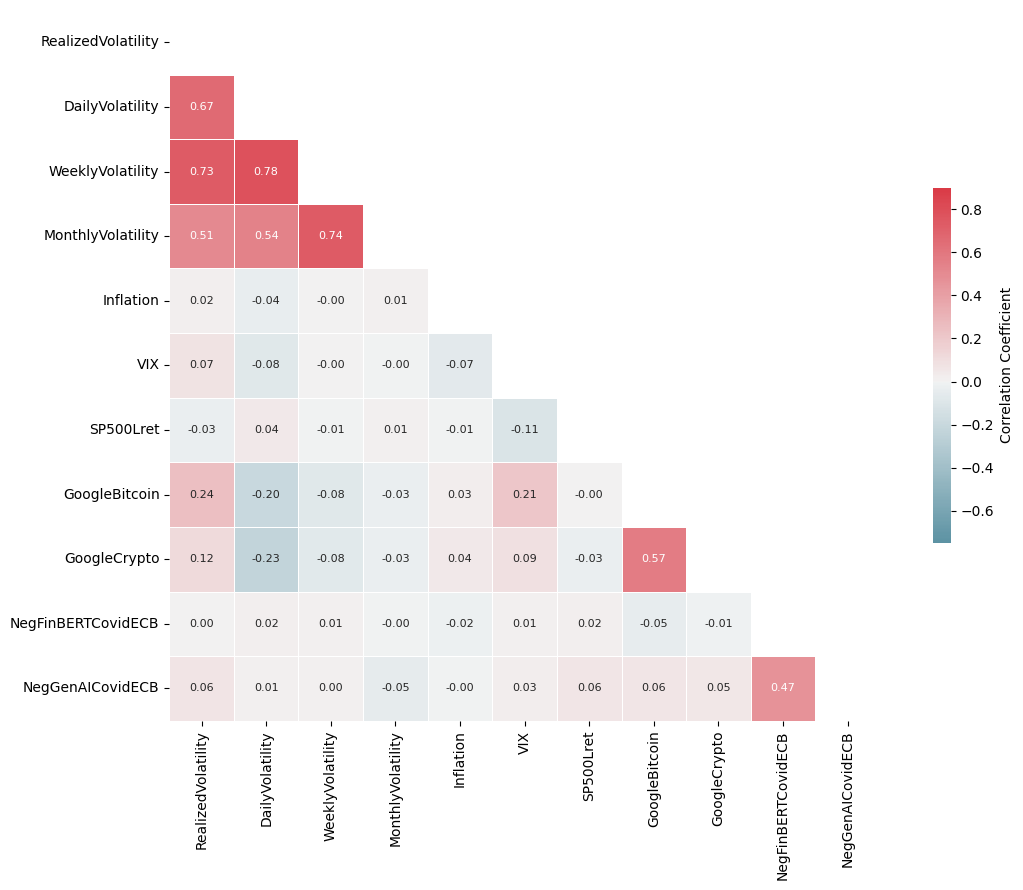

In [22]:
df = pd.read_csv('finaldataset.csv')
df.set_index(df['Date'], inplace=True, drop=True)
df = df.iloc[:,2:]
corr = df[["RealizedVolatility", "DailyVolatility", "WeeklyVolatility", "MonthlyVolatility", "Inflation", "VIX", "SP500Lret", "GoogleBitcoin", "GoogleCrypto", "NegFinBERTCovidECB", "NegGenAICovidECB"]]

corr = corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 9))  # Increased figure size

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Adjusted for contrast

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, vmin=-0.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
            annot=True, fmt=".2f", annot_kws={"size": 8})  # Adjusted font size

plt.xticks(fontsize=10)  # Adjust x-axis labels font size
plt.yticks(fontsize=10)  # Adjust y-axis labels font size
plt.tight_layout()
#plt.savefig('corrmatrixshort.pdf', bbox_inches='tight')
plt.show()